## The code is borrowed from the following link
- [Original Code](https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Assignment_4_ref_codes.ipynb)

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, SimpleRNN
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
import os

## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Dataset
The dataset is located at **data** folder. The \"small_vocab_en\" contains English senteces and the "small_vocab_fr" contains the corresponding French translation. 

In [7]:
#Loading data
def load_data(path):
    data_file = os.path.join(path)
    with open(data_file,"r") as f:
        lang_data = f.read()
    return lang_data.split('\n')

In [9]:
# Load English data
english_sentences = load_data('small_vocab_en.txt')
# Load French data
french_sentences = load_data('small_vocab_fr.txt')
print('Dataset Loaded')

Dataset Loaded


### Visualize data
Each line in small_vocab_en contains an English sentence with the respective translation in each line of small_vocab_fr. View the first two lines from each file.

In [11]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre .


### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary. A more complex vocabulary is a more complex problem. Let's look at the complexity of the dataset we'll be working with.

In [13]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:

Tokenize the words into ids
Add padding to make all the sequences the same length.
Time to start preprocessing the data...

#### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings. Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number. These are called character and word ids, respectively. Character ids are used for character level models that generate text predictions for each character. A word level model uses word ids that generate text predictions for each word. Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's Tokenizer function. Use this function to tokenize english_sentences and french_sentences in the cell below.

Running the cell will run tokenize on sample data and show output for debugging.

In [16]:
def tokenize(x):
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

### Padding (IMPLEMENTATION)  
When batching the sequence of word ids together, each sequence needs to be the same length. Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the end of each sequence using Keras's pad_sequences function.

In [18]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline. Instead, we've provided you with the implementation of the preprocess function.

In [20]:
def preprocess(x, y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    return preprocess_x, preprocess_y, x_tk, y_tk

# Preprocess data
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)

max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index) + 1

In [21]:
# Prepare data for training
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want. We want the French translation. The function logits_to_text will bridge the gab between the logits from the neural network to the French translation. You'll be using this function to better understand the output of the neural network.

In [23]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

<h1>Adding New Models RNN,LSTM & GRU models</h1>

In [28]:
#RNN model
def stacked_rnn_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 0.001
    model = Sequential()
    model.add(SimpleRNN(128, return_sequences=True, input_shape=input_shape[1:]))
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    
    model.compile(loss=sparse_categorical_crossentropy,
                 optimizer=Adam(learning_rate),
                 metrics=['accuracy'])
    return model

In [30]:
# Model 2: Stacked (2-layer) LSTM
def stacked_lstm_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 0.001
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape[1:]))
    model.add(LSTM(128, return_sequences=True))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    
    model.compile(loss=sparse_categorical_crossentropy,
                 optimizer=Adam(learning_rate),
                 metrics=['accuracy'])
    return model

In [32]:
# Model 3: Stacked (2-layer) GRU
def stacked_gru_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 0.001
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape[1:]))
    model.add(GRU(128, return_sequences=True))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    
    model.compile(loss=sparse_categorical_crossentropy,
                 optimizer=Adam(learning_rate),
                 metrics=['accuracy'])
    return model


In [34]:
# Train all models and record history
models = {
    'Stacked_RNN': stacked_rnn_model(tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size),
    'Stacked_LSTM': stacked_lstm_model(tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size),
    'Stacked_GRU': stacked_gru_model(tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size)
}

history_dict = {}
training_times = {}

In [35]:
# Train each model
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    
    history = model.fit(tmp_x, preproc_french_sentences, 
                       batch_size=1024, 
                       epochs=20, 
                       validation_split=0.2,
                       verbose=1)
    
    end_time = time.time()
    training_times[name] = end_time - start_time
    history_dict[name] = history


Training Stacked_RNN...
Epoch 1/20
108/108 [==============================] - 99s 143ms/step - loss: 2.5456 - accuracy: 0.4890 - val_loss: 1.8811 - val_accuracy: 0.5729
Epoch 2/20
108/108 [==============================] - 18s 168ms/step - loss: 1.6747 - accuracy: 0.5874 - val_loss: 1.5452 - val_accuracy: 0.5993
Epoch 3/20
108/108 [==============================] - 16s 145ms/step - loss: 1.4798 - accuracy: 0.6101 - val_loss: 1.4185 - val_accuracy: 0.6186
Epoch 4/20
108/108 [==============================] - 18s 140ms/step - loss: 1.3673 - accuracy: 0.6317 - val_loss: 1.3182 - val_accuracy: 0.6386
Epoch 5/20
108/108 [==============================] - 15s 138ms/step - loss: 1.2839 - accuracy: 0.6426 - val_loss: 1.2478 - val_accuracy: 0.6477
Epoch 6/20
108/108 [==============================] - 18s 164ms/step - loss: 1.2228 - accuracy: 0.6518 - val_loss: 1.1940 - val_accuracy: 0.6587
Epoch 7/20
108/108 [==============================] - 19s 181ms/step - loss: 1.1759 - accuracy: 0.6577 - v

In [38]:
# Generate predictions and sample translations
sample_indices = range(10)
sample_translations = {}

for name, model in models.items():
    predictions = model.predict(tmp_x[sample_indices])
    translations = []
    for i in sample_indices:
        original_english = english_sentences[i]
        predicted_french = logits_to_text(predictions[i], french_tokenizer)
        actual_french = french_sentences[i]
        translations.append({
            'English': original_english,
            'Predicted_French': predicted_french,
            'Actual_French': actual_french
        })
    sample_translations[name] = translations

1/1 [==============================] - 3s 3s/step


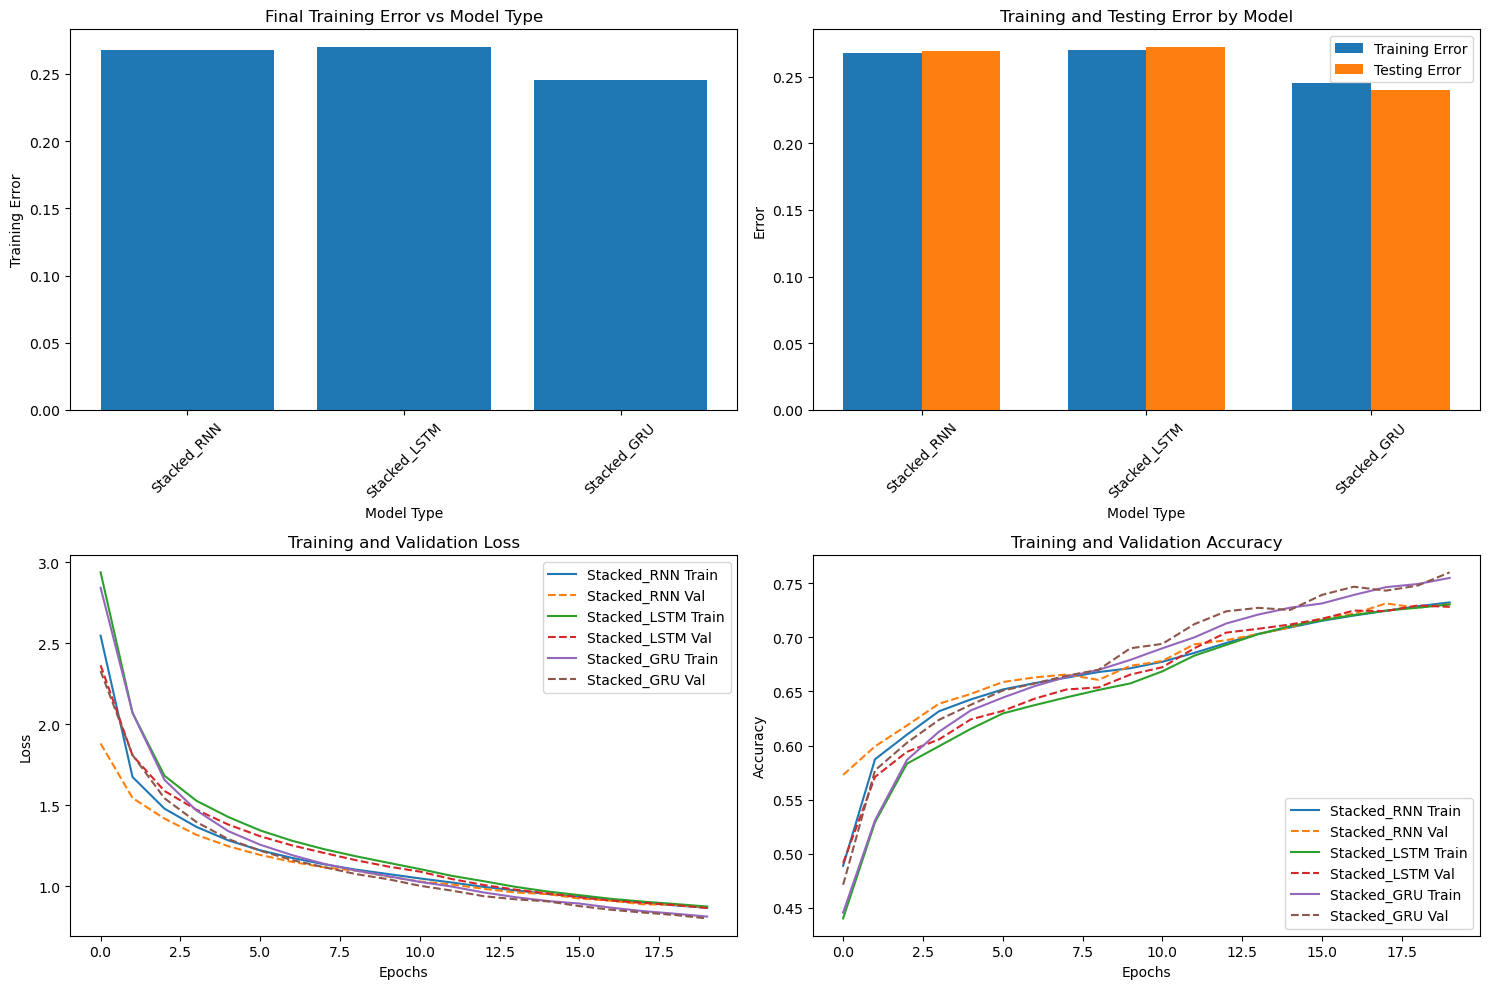


SAMPLE TRANSLATIONS

Stacked_RNN Translations:
--------------------------------------------------
Sample 1:
  English: new jersey is sometimes quiet during autumn , and it is snowy in april .
  Predicted French: new jersey est parfois chaud en mois de il et il est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
  Actual French: new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

Sample 2:
  English: the united states is usually chilly during july , and it is usually freezing in november .
  Predicted French: les ã©tats unis est gã©nã©ralement pluvieux en juillet et il est gã©nã©ralement agrã©able en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
  Actual French: les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre .

Sample 3:
  English: california is usually quiet during march , and it is usually hot in june .
  Predicted French: californie est gã©nã©ralement calme en l' et il est est gã©nã©ralement en juin <PAD> <PAD> <P

In [40]:
# Plotting results
plt.figure(figsize=(15, 10))

# Plot 1: Training error vs Training time
plt.subplot(2, 2, 1)
final_train_errors = []
for name in models.keys():
    final_train_error = 1 - history_dict[name].history['accuracy'][-1]
    final_train_errors.append(final_train_error)

plt.bar(models.keys(), final_train_errors)
plt.title('Final Training Error vs Model Type')
plt.xlabel('Model Type')
plt.ylabel('Training Error')
plt.xticks(rotation=45)

# Plot 2: Training and testing error vs Training time
plt.subplot(2, 2, 2)
train_errors = []
test_errors = []
for name in models.keys():
    train_error = 1 - history_dict[name].history['accuracy'][-1]
    test_error = 1 - history_dict[name].history['val_accuracy'][-1]
    train_errors.append(train_error)
    test_errors.append(test_error)

x = np.arange(len(models.keys()))
width = 0.35
plt.bar(x - width/2, train_errors, width, label='Training Error')
plt.bar(x + width/2, test_errors, width, label='Testing Error')
plt.xlabel('Model Type')
plt.ylabel('Error')
plt.title('Training and Testing Error by Model')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()

# Plot 3: Loss vs Epochs
plt.subplot(2, 2, 3)
for name in models.keys():
    plt.plot(history_dict[name].history['loss'], label=f'{name} Train')
    plt.plot(history_dict[name].history['val_loss'], label=f'{name} Val', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot 4: Accuracy vs Epochs
plt.subplot(2, 2, 4)
for name in models.keys():
    plt.plot(history_dict[name].history['accuracy'], label=f'{name} Train')
    plt.plot(history_dict[name].history['val_accuracy'], label=f'{name} Val', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print sample translations
print("\n" + "="*80)
print("SAMPLE TRANSLATIONS")
print("="*80)

for model_name, translations in sample_translations.items():
    print(f"\n{model_name} Translations:")
    print("-" * 50)
    for i, trans in enumerate(translations):
        print(f"Sample {i+1}:")
        print(f"  English: {trans['English']}")
        print(f"  Predicted French: {trans['Predicted_French']}")
        print(f"  Actual French: {trans['Actual_French']}")
        print()

# Print performance summary
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
for name in models.keys():
    final_train_acc = history_dict[name].history['accuracy'][-1]
    final_val_acc = history_dict[name].history['val_accuracy'][-1]
    print(f"\n{name}:")
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Training Time: {training_times[name]:.2f} seconds")